In [27]:
import random
import os
import sys
import xml.etree.ElementTree as ET
import traci
import shutil
import matplotlib.pyplot as plt
import logging
import subprocess
import csv
import numpy as np


os.environ['SUMO_HOME'] = '/System/Volumes/Data/opt/homebrew/Cellar/sumo/1.19.0/share/sumo'

if 'SUMO_HOME' in os.environ:
    tools = os.path.join(os.environ['SUMO_HOME'], 'tools')
    sys.path.append(tools)


# Disable INFO level messages from SUMO
logging.getLogger('sumo').setLevel(logging.WARNING)


## Particle, PSO, and SUMO Definitions & Setup
- Setup for PSO and running the SUMO sim.

In [2]:

class Particle:
    def __init__(self, initial_position):
        self.position = initial_position.copy()
        self.velocity = [random.uniform(-1, 1) for _ in range(len(initial_position))]
        self.best_position = self.position.copy()
        self.best_fitness = float('inf')

'''
Initialize the particles with the initial timings
'''
def initialize_particles(num_particles, initial_timings):
    particles = [Particle(initial_timings) for _ in range(num_particles)]
    return particles

'''
Modify the network file with the new traffic light timings
'''
def modify_network_xml(durations, network_file, modified_network_file):
    shutil.copy(network_file, modified_network_file)
    tree = ET.parse(modified_network_file)
    root = tree.getroot()

    for tl in root.findall('tlLogic'):
        phases = tl.findall('phase')
        for i in range(0, len(phases), 4):
            phases[i].set('duration', str(int(durations[0])))
            phases[i + 1].set('duration', str(int(durations[1])))
            phases[i + 2].set('duration', str(int(durations[0])))
            phases[i + 3].set('duration', str(int(durations[1])))

    tree.write(modified_network_file)

'''
Run the sumo simulation with the modified network file
Return the wanted fitness parameter (either travel time or waiting time)
'''
def run_sumo_simulation(config_file, modified_network_file, tripinfo_file, fitness_param):
    sumo_command = ['sumo', '-c', config_file, '--net-file', modified_network_file, '--tripinfo-output', tripinfo_file, '--start', '--quit-on-end', '--scale', '1']
    
    vehicle_id = "10"
    fitness = 0
    process = subprocess.Popen(sumo_command, stdout=subprocess.PIPE, stderr=subprocess.PIPE)
    stdout, stderr = process.communicate()
    
    if process.returncode != 0:
        print(f"Error running SUMO simulation: {stderr}")
        return None
    
    # Get the total travel time of the vehicle from the tripinfo file
    tree = ET.parse(tripinfo_file)
    root = tree.getroot()
    for trip in root.findall('tripinfo'):
        if trip.get('id') == vehicle_id:
            if fitness_param == 'travel_time':
                fitness = float(trip.get('duration'))
            elif fitness_param == 'waiting_time':
                fitness = float(trip.get('waitingTime'))

    # return fitness (either travel_time or waiting time)
    return fitness


'''
Modify the network file with the new traffic light timings
Run the sumo simulation with the modified network file and get the desired fitness value (either travel time or waiting time)
'''
def evaluate_fitness(durations, config_file, network_file, tripinfo_file, modified_network_file, fitness_param):
    modify_network_xml(durations, network_file, modified_network_file)
    fitness_value = run_sumo_simulation(config_file, modified_network_file, tripinfo_file, fitness_param)
    return fitness_value

'''
Run PSO algorithm to optimize the traffic light timings
'''
def pso(num_particles, w, c1, s1, max_iterations, min_duration, max_duration, num_phases, initial_timings, config_file, network_file, tripinfo_file, modified_network_file, fitness_param):
    global_best_position = initial_timings.copy()
    global_best_fitness = float('inf')
    fitness_values = []

    for iteration in range(max_iterations):
        particles = []
        # Initialize the particles
        for _ in range(num_particles):
            position = [random.randint(min_duration, max_duration) for _ in range(num_phases)]
            velocity = [random.uniform(-1, 1) for _ in range(num_phases)]
            particle = {
                'position': position,
                'velocity': velocity,
                'best_position': position.copy(),
                'best_fitness': float('inf')
            }
            particles.append(particle)
        
        for particle in particles:
            # Evaluate the fitness of the particle
            fitness = evaluate_fitness(particle['position'], config_file, network_file, tripinfo_file, modified_network_file, fitness_param)

            # Update the best position and fitness of the particle
            if fitness < particle['best_fitness']:
                particle['best_position'] = particle['position'].copy()
                particle['best_fitness'] = fitness

            # Update the best position and fitness of the swarm
            if fitness < global_best_fitness:
                global_best_position = particle['position'].copy()
                global_best_fitness = fitness
        
            fitness_values.append(global_best_fitness)
            # print(f"----Iteration {iteration}, Particle fitness: {fitness}, Global best fitness: {global_best_fitness}")
            # print(f"----Durations: {particle['position']}, Global best durations: {global_best_position}")

        for particle in particles:
            for i in range(num_phases):
                # update the velocity and position of the particle
                r1 = random.random()
                r2 = random.random()
                cognitive_component = c1 * r1 * (particle['best_position'][i] - particle['position'][i])
                social_component = s1 * r2 * (global_best_position[i] - particle['position'][i])
                
                # Update the velocity and position of the particle
                particle['velocity'][i] = w * particle['velocity'][i] + cognitive_component + social_component
                particle['velocity'][i] = max(min(-max_duration, particle['velocity'][i]), max_duration)
                particle['position'][i] += particle['velocity'][i]
                particle['position'][i] = max(min_duration, min(max_duration, particle['position'][i]))

        # Modify the network file with the best traffic light timings
        modify_network_xml(global_best_position, network_file, modified_network_file)
        print(f"Iteration {iteration}: Best traffic light timings: {global_best_position[0:2]}, Best fitness: {global_best_fitness}")

    return global_best_position, global_best_fitness, fitness_values



## Run function
- Driver for the program. Will run PSO and SUMO with the specified parameters

In [3]:
'''
# num_particles = Number of particles               [20, 40, 60, 80, 100]
# w = Inertia weight                                [0.2, 0.4, 0.6, 0.8, 1.0]
# c1 = Cognitive component                          [0.8, 1.6, 2.4, 3.2, 4.0]
# s1 = 1.6 # Social component                       [0.8, 1.6, 2.4, 3.2, 4.0]

Run the PSO optimization with the given parameters
'''
def run(fitness_param, num_particles, w, c1, s1):
    max_iterations = 1                  # Number of iterations
    min_duration = 5                    # Minimum phase duration          #MENTION
    max_duration = 30                   # Maximum phase duration          #MENTION
    num_phases = 2                      # Number of traffic light phases
    initial_timings = [10, 5, 10, 5]    # Initial traffic light timings
    
    
    # Paths to SUMO files
    sumo_config_file = '../sumo_files/config.sumo.cfg'
    network_file = '../sumo_files/network.net.xml'
    tripinfo_file = '../sumo_files/tripinfo.xml'
    modified_network_file = '../sumo_files/network_modified.net.xml'

    # Create the modified network file if it doesn't exist
    if not os.path.exists(modified_network_file):
        os.makedirs(os.path.dirname(modified_network_file), exist_ok=True)
        shutil.copy(network_file, modified_network_file)

    # Run the PSO optimization
    best_timings, best_fitness, fitness_values = pso(num_particles, w, c1, s1, max_iterations, min_duration, max_duration, num_phases, initial_timings, sumo_config_file, network_file, tripinfo_file, modified_network_file, fitness_param)

    # Output the final best traffic light timings and fitness
    print("Final best traffic light timings:", best_timings)
    print("Final best fitness:", best_fitness)
    return fitness_values, best_fitness, best_timings


## Default Parameter Runs
- Runs to get both the best _total waiting time_ and _total travel time_

### Default Parameters
1. num_particles = 60
2. inertia = 0.6
3. cognition = 1.6
4. social = 1.6

In [16]:
fitness_values_waiting_time, best_fitness_waiting_time, best_timing_waiting_time = run('waiting_time', num_particles=60, w=0.6, c1=1.6, s1=1.6)
print("Fitness values (WAITING TIME)",fitness_values_waiting_time)
print("Best fitness (WAITING TIME)",best_fitness_waiting_time)
print("Best timings (WAITING TIME)",best_timing_waiting_time)

fitness_values_travel_time, best_fitness_travel_time, best_timing_travel_time = run('travel_time', num_particles=60, w=0.6, c1=1.6, s1=1.6)
print("Fitness values (TRAVEL TIME)",fitness_values_travel_time)
print("Best fitness (TRAVEL TIME)",best_fitness_travel_time)

Iteration 0: Best traffic light timings: [28, 5], Best fitness: 30.0
Final best traffic light timings: [28, 5]
Final best fitness: 30.0
Fitness values (WAITING TIME) [196.0, 78.0, 57.0, 57.0, 57.0, 51.0, 51.0, 45.0, 45.0, 45.0, 33.0, 33.0, 33.0, 33.0, 33.0, 33.0, 33.0, 33.0, 33.0, 33.0, 33.0, 33.0, 33.0, 33.0, 33.0, 33.0, 33.0, 33.0, 33.0, 31.0, 31.0, 31.0, 31.0, 31.0, 31.0, 31.0, 31.0, 31.0, 30.0, 30.0, 30.0, 30.0, 30.0, 30.0, 30.0, 30.0, 30.0, 30.0, 30.0, 30.0, 30.0, 30.0, 30.0, 30.0, 30.0, 30.0, 30.0, 30.0, 30.0, 30.0]
Best fitness (WAITING TIME) 30.0
Best timings (WAITING TIME) [28, 5]
Iteration 0: Best traffic light timings: [30, 5], Best fitness: 74.0
Final best traffic light timings: [30, 5]
Final best fitness: 74.0
Fitness values (TRAVEL TIME) [110.0, 110.0, 110.0, 110.0, 110.0, 81.0, 81.0, 81.0, 81.0, 81.0, 81.0, 81.0, 81.0, 81.0, 74.0, 74.0, 74.0, 74.0, 74.0, 74.0, 74.0, 74.0, 74.0, 74.0, 74.0, 74.0, 74.0, 74.0, 74.0, 74.0, 74.0, 74.0, 74.0, 74.0, 74.0, 74.0, 74.0, 74.0, 74.0

## Different Particle Values
- Run 5 times for each fitness, once for each particle value: [20, 40, 60, 80, 100]
- All other params will be kept at their default

In [5]:

# loop and run 5 times, once for eahc fitness value. Store in a list for each iteration as so: "20": [fitness_values_waiting_time, best_fitness_waiting_time, best_timing_waiting_time]
num_particles = [20, 40, 60, 80, 100]
travel_time_particles = {"20": [], "40": [], "60": [], "80": [], "100": []}
waiting_time_particles = {"20": [], "40": [], "60": [], "80": [], "100": []}

for num in num_particles:
    fitness_values_travel_time_particles, best_fitness_travel_time_particles, best_timing_travel_time_particles = run('travel_time', num_particles=num, w=0.6, c1=1.6, s1=1.6)
    fitness_values_waiting_time_particles, best_fitness_waiting_time_particles, best_timing_waiting_time_particles = run('waiting_time', num_particles=num, w=0.6, c1=1.6, s1=1.6)
    
    travel_time_particles[str(num)] = [fitness_values_travel_time_particles, best_fitness_travel_time_particles, best_timing_travel_time_particles]
    waiting_time_particles[str(num)] = [fitness_values_waiting_time_particles, best_fitness_waiting_time_particles, best_timing_waiting_time_particles]

print(travel_time_particles)
print(waiting_time_particles)   

Iteration 0: Best traffic light timings: [27, 6], Best fitness: 73.0
Final best traffic light timings: [27, 6]
Final best fitness: 73.0
Iteration 0: Best traffic light timings: [15, 5], Best fitness: 31.0
Final best traffic light timings: [15, 5]
Final best fitness: 31.0
Iteration 0: Best traffic light timings: [30, 7], Best fitness: 78.0
Final best traffic light timings: [30, 7]
Final best fitness: 78.0
Iteration 0: Best traffic light timings: [12, 5], Best fitness: 32.0
Final best traffic light timings: [12, 5]
Final best fitness: 32.0
Iteration 0: Best traffic light timings: [22, 7], Best fitness: 72.0
Final best traffic light timings: [22, 7]
Final best fitness: 72.0
Iteration 0: Best traffic light timings: [5, 5], Best fitness: 24.0
Final best traffic light timings: [5, 5]
Final best fitness: 24.0
Iteration 0: Best traffic light timings: [26, 5], Best fitness: 68.0
Final best traffic light timings: [26, 5]
Final best fitness: 68.0
Iteration 0: Best traffic light timings: [5, 5], B

## Different Inertia Values
- Run 5 times for each fitness, once for each inertia value [0.2, 0.4, 0.6, 0.8, 1.0]
- All other params will be kept at their default

In [6]:
inertia_weights = [0.2, 0.4, 0.6, 0.8, 1.0]
travel_time_inertia_weights = {"0.2": [], "0.4": [], "0.6": [], "0.8": [], "1.0": []}
waiting_time_inertia_weights = {"0.2": [], "0.4": [], "0.6": [], "0.8": [], "1.0": []}

for weight in inertia_weights:
    fitness_values_travel_time_inertia_weights, best_fitness_travel_time_inertia_weights, best_timing_travel_time_inertia_weights = run('travel_time', num_particles=60, w=weight, c1=1.6, s1=1.6)
    fitness_values_waiting_time_inertia_weights, best_fitness_waiting_time_inertia_weights, best_timing_waiting_time_inertia_weights = run('waiting_time', num_particles=60, w=weight, c1=1.6, s1=1.6)
    
    travel_time_inertia_weights[str(weight)] = [fitness_values_travel_time_inertia_weights, best_fitness_travel_time_inertia_weights, best_timing_travel_time_inertia_weights]
    waiting_time_inertia_weights[str(weight)] = [fitness_values_waiting_time_inertia_weights, best_fitness_waiting_time_inertia_weights, best_timing_waiting_time_inertia_weights]


print(travel_time_inertia_weights)
print(waiting_time_inertia_weights)

Iteration 0: Best traffic light timings: [21, 5], Best fitness: 64.0
Final best traffic light timings: [21, 5]
Final best fitness: 64.0
Iteration 0: Best traffic light timings: [25, 5], Best fitness: 29.0
Final best traffic light timings: [25, 5]
Final best fitness: 29.0
Iteration 0: Best traffic light timings: [29, 8], Best fitness: 78.0
Final best traffic light timings: [29, 8]
Final best fitness: 78.0
Iteration 0: Best traffic light timings: [5, 5], Best fitness: 24.0
Final best traffic light timings: [5, 5]
Final best fitness: 24.0
Iteration 0: Best traffic light timings: [28, 7], Best fitness: 77.0
Final best traffic light timings: [28, 7]
Final best fitness: 77.0
Iteration 0: Best traffic light timings: [29, 5], Best fitness: 29.0
Final best traffic light timings: [29, 5]
Final best fitness: 29.0
Iteration 0: Best traffic light timings: [26, 6], Best fitness: 71.0
Final best traffic light timings: [26, 6]
Final best fitness: 71.0
Iteration 0: Best traffic light timings: [30, 5], 

## Different values & combinations for Social & Cognition
- Run for each fitness for each combination of social and cognition parameters
    - Social: [0.8, 1.6, 2.4, 3.2, 4.0]
    - Cognition: [0.8, 1.6, 2.4, 3.2, 4.0]
- Inertia and particles will be set to their defaults

In [9]:
social_values = [0.8, 1.6, 2.4, 3.2, 4.0]
cognition_values = [0.8, 1.6, 2.4, 3.2, 4.0]

# need to define these maps differently
travel_time_social_cognition = {}
waiting_time_social_cognition = {}

for social in social_values:
    for cognition in cognition_values:
        print("-------------------- Social: ", social, "Cognition: ", cognition, "--------------------")
        fitness_values_travel_time_social_cognition, best_fitness_travel_time_social_cognition, best_timing_travel_time_social_cognition = run('travel_time', num_particles=60, w=0.6, c1=cognition, s1=social)
        fitness_values_waiting_time_social_cognition, best_fitness_waiting_time_social_cognition, best_timing_waiting_time_social_cognition = run('waiting_time', num_particles=60, w=0.6, c1=cognition, s1=social)
        
        # Make sure these exist before adding to the map
        travel_time_social_cognition[str(social) + "_" + str(cognition)] = []
        waiting_time_social_cognition[str(social) + "_" + str(cognition)] = []
        
        travel_time_social_cognition[str(social) + "_" + str(cognition)] = [fitness_values_travel_time_social_cognition, best_fitness_travel_time_social_cognition, best_timing_travel_time_social_cognition]
        waiting_time_social_cognition[str(social) + "_" + str(cognition)] = [fitness_values_waiting_time_social_cognition, best_fitness_waiting_time_social_cognition, best_timing_waiting_time_social_cognition]

# display
print(travel_time_social_cognition)
print(waiting_time_social_cognition)

-------------------- Social:  0.8 Cognition:  0.8 --------------------
Iteration 0: Best traffic light timings: [21, 5], Best fitness: 64.0
Final best traffic light timings: [21, 5]
Final best fitness: 64.0
Iteration 0: Best traffic light timings: [22, 7], Best fitness: 27.0
Final best traffic light timings: [22, 7]
Final best fitness: 27.0
-------------------- Social:  0.8 Cognition:  1.6 --------------------
Iteration 0: Best traffic light timings: [23, 6], Best fitness: 73.0
Final best traffic light timings: [23, 6]
Final best fitness: 73.0
Iteration 0: Best traffic light timings: [15, 5], Best fitness: 31.0
Final best traffic light timings: [15, 5]
Final best fitness: 31.0
-------------------- Social:  0.8 Cognition:  2.4 --------------------
Iteration 0: Best traffic light timings: [27, 5], Best fitness: 71.0
Final best traffic light timings: [27, 5]
Final best fitness: 71.0
Iteration 0: Best traffic light timings: [29, 5], Best fitness: 29.0
Final best traffic light timings: [29,

## Writing to CSV
- For each of the experiments, there are two csv files: one for the travel time fitness values and one for the waiting time fitness values.

### Formatting of CSV Files
- DEFAULT PARAMETERS
    - Column name: 'Fitness_values_*travel_time*' | 'Fitness_values_*waiting_time*'
    - Values: Fitness values over each particle

- NUM PARTICLES
    - Column name: the number of particles used -> '*20*' | '*40*' | '*60*' | '*80*' | '*100*'
    - Values: Fitness values over each particle up to their specified number of particles (20 has 20 values, 40 has 40 values, etc)

- INERTIA WEIGHTS
    - Column name: the inertia value -> '*0.2*' | '*0.4*' | '*0.6*' | '*0.8*' | '*1.0*'
    - Values: Fitness values over each particle using the specified inertia weight value

- SOCIAL & COGNITION 
    - Column name: the social & cognition combination (social_cognition) -> '*0.8_0.8*' | '*0.8_1.6*' | '*0.8_2.4*' | '*0.8_3.2*' | '*0.8_4.0*' etc.
    - Values: Fitness values over each particle using the specified combination of social and cognition. 

In [33]:
def write_to_csv(data_dict, filename):
    # Determine the maximum number of values associated with any key
    max_values = max(len(value[0]) for value in data_dict.values())
    
    # Create a list of lists for CSV rows
    csv_rows = []

    # Append header row with keys
    header_row = list(data_dict.keys())
    csv_rows.append(header_row)

    # Append data rows
    for i in range(max_values):
        row = []
        for key, value in data_dict.items():
            if i < len(value[0]):
                row.append(value[0][i])
            else:
                row.append(None)
        csv_rows.append(row)

    # Write data to CSV file
    with open(filename, 'w', newline='') as csvfile:
        writer = csv.writer(csvfile)
        writer.writerows(csv_rows)

In [34]:
# --------------------- DEFAULT PARAMETER FITNESS VALUES OVER PARTICLES ---------------------
with open('../data/default_parameters_waiting_time.csv', 'w') as f:
    f.write('fitness_values_waiting_time\n')
    for value in fitness_values_waiting_time:
        f.write(f'{value}\n')

with open('../data/default_parameters_travel_time.csv', 'w') as f:
    f.write('fitness_values_travel_time\n')
    for value in fitness_values_travel_time:
        f.write(f'{value}\n')
        
        
# --------------------- PARTICLES ---------------------
write_to_csv(travel_time_particles, '../data/num_particles_travel_time.csv')
write_to_csv(waiting_time_particles, '../data/num_particles_waiting_time.csv')

# --------------------- INERTIA WEIGHTS ---------------------
write_to_csv(travel_time_inertia_weights, '../data/inertia_weights_travel_time.csv')
write_to_csv(waiting_time_inertia_weights, '../data/inertia_weights_waiting_time.csv')

# --------------------- SOCIAL AND COGNITIVE COMPONENTS ---------------------
write_to_csv(travel_time_social_cognition, '../data/social_cognition_travel_time.csv')
write_to_csv(waiting_time_social_cognition, '../data/social_cognition_waiting_time.csv')

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

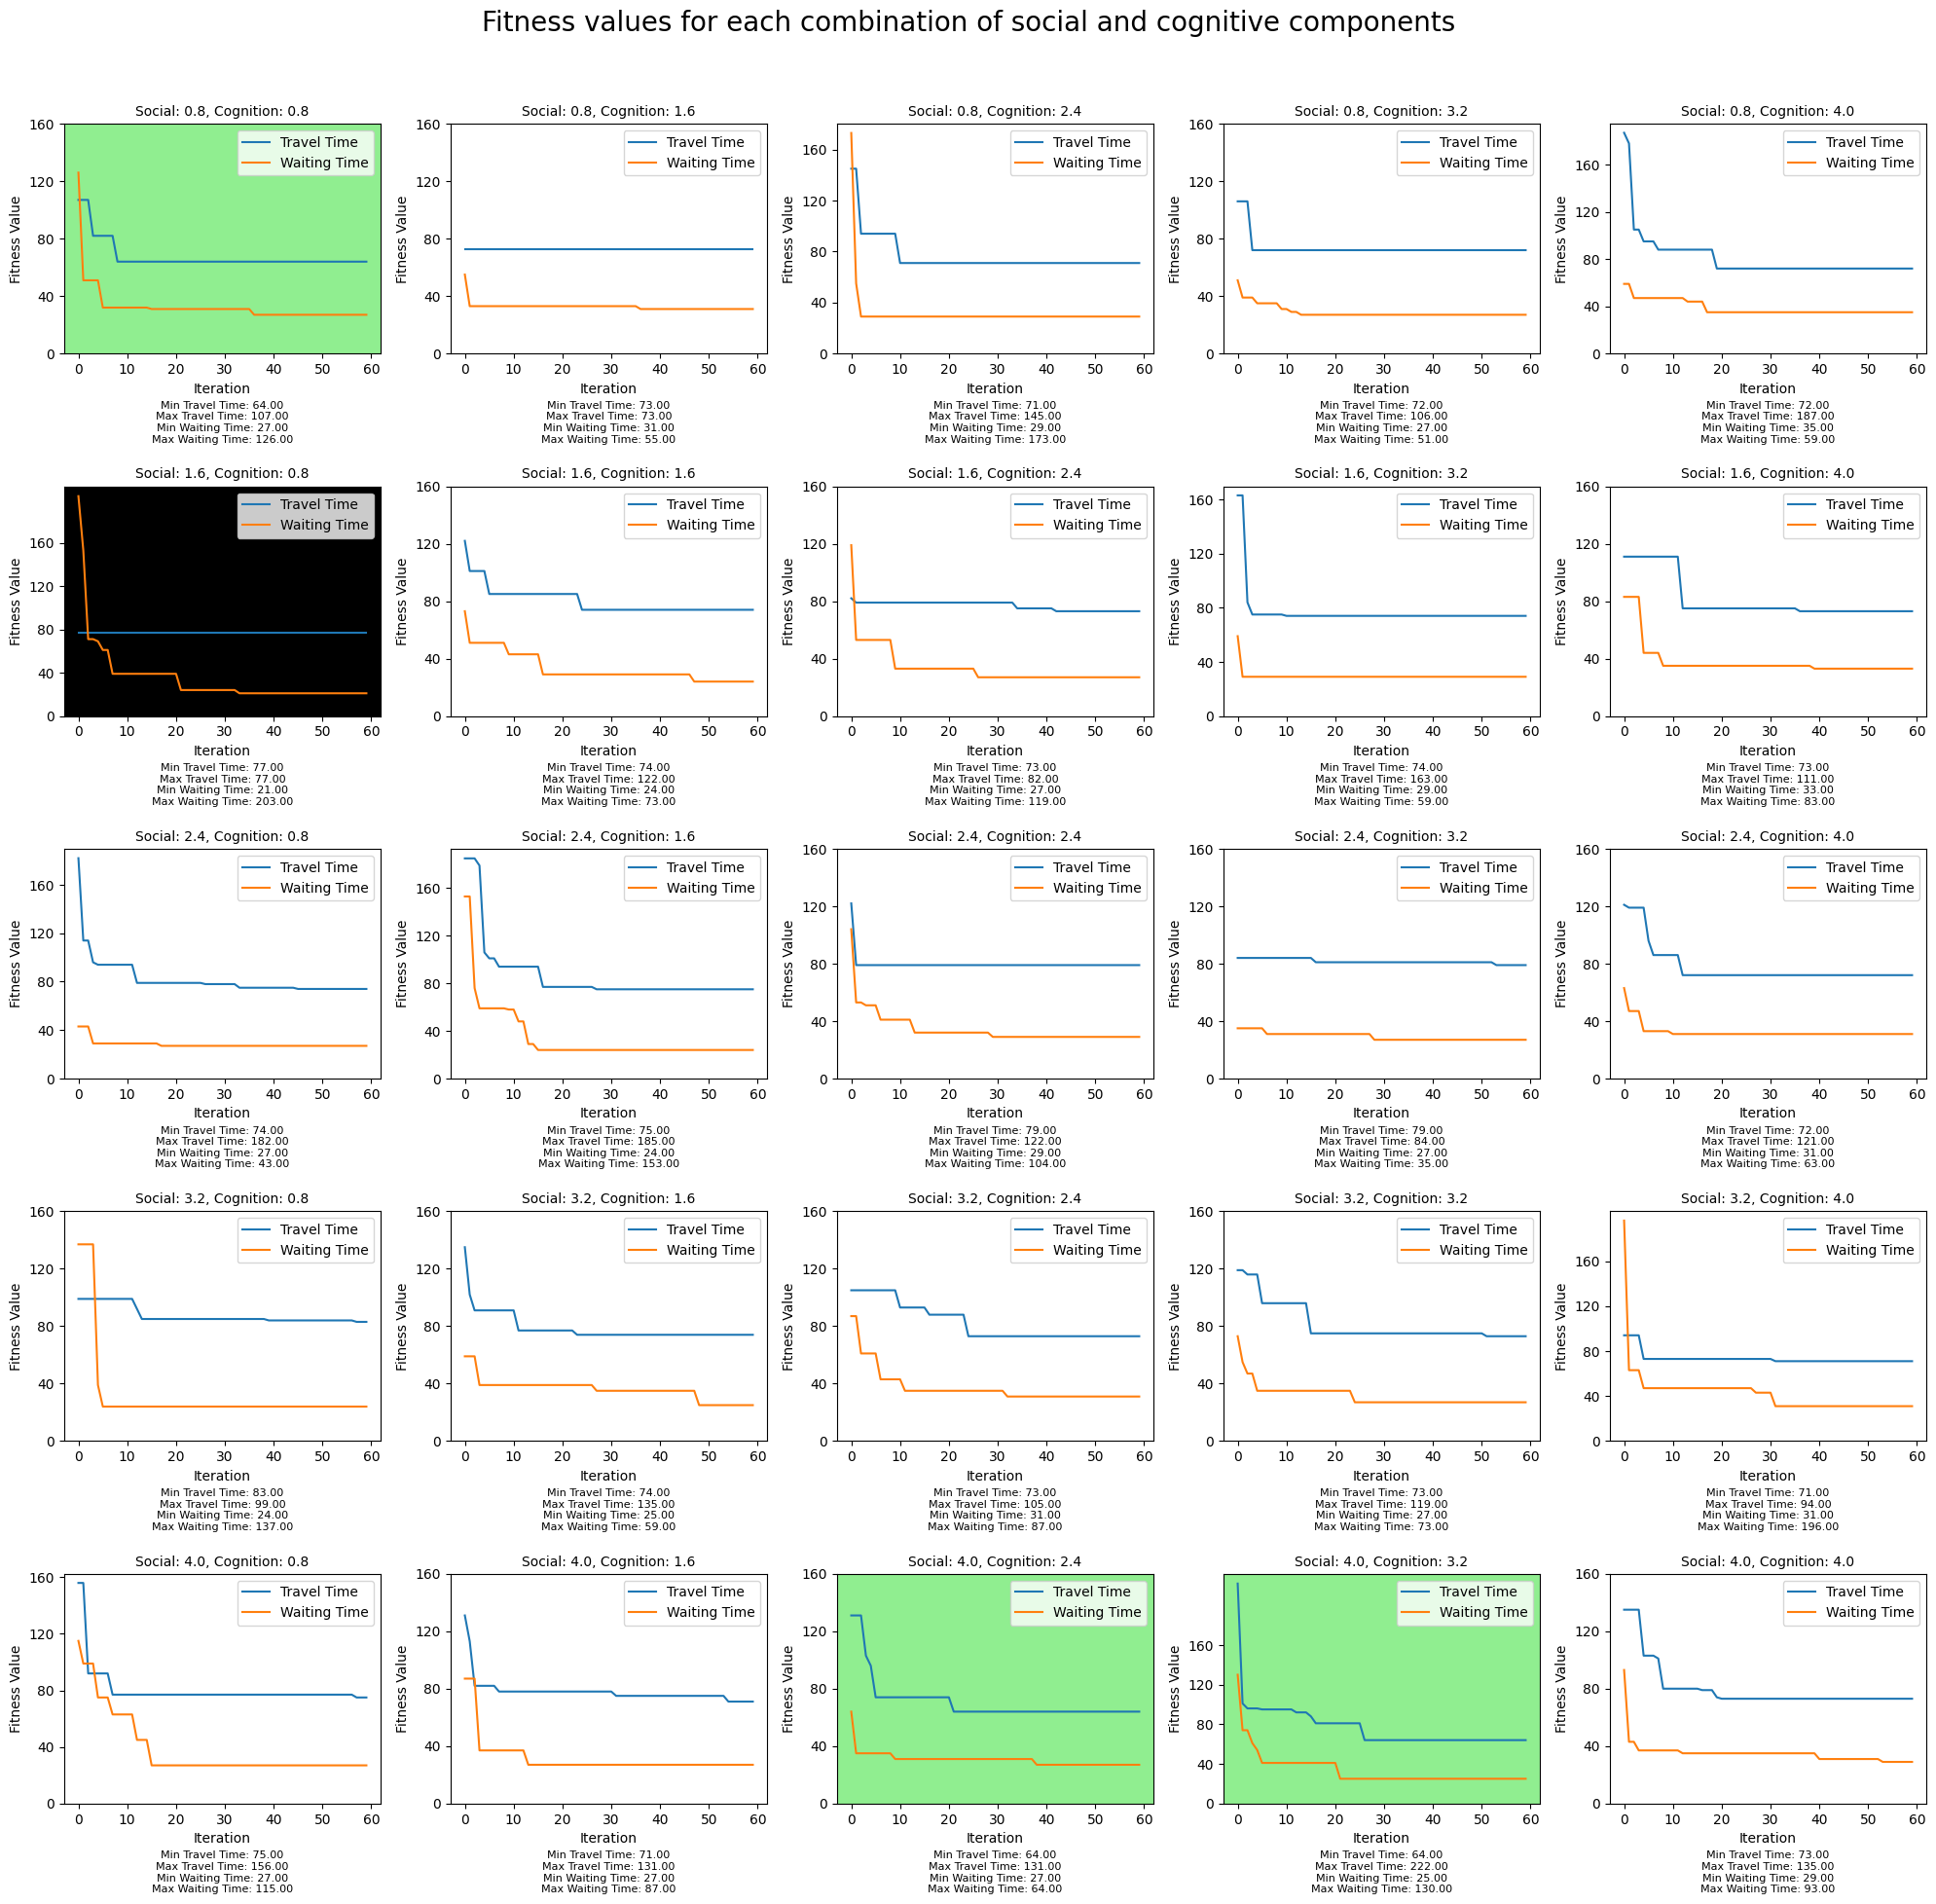

In [5]:
""" CSV format:
    - Column name: the social & cognition combination (social_cognition) -> '*0.8_0.8*' | '*0.8_1.6*' | '*0.8_2.4*' | '*0.8_3.2*' | '*0.8_4.0*' etc.
    - Values: Fitness values over each particle using the specified combination of social and cognition.
"""

# Read the CSV files
social_cognition_travel_time_df = pd.read_csv('../data/social_cognition_travel_time.csv')
social_cognition_waiting_time_df = pd.read_csv('../data/social_cognition_waiting_time.csv')

fig, ax = plt.subplots(5, 5, figsize=(20, 20))
fig.suptitle('Fitness values for each combination of social and cognitive components', fontsize=20)

for i in range(5):
    for j in range(5):
        social_cognition = social_cognition_travel_time_df.columns[i*5 + j]
        ax[i, j].plot(social_cognition_travel_time_df[social_cognition], label='Travel Time')
        ax[i, j].plot(social_cognition_waiting_time_df[social_cognition], label='Waiting Time')
        social = social_cognition.split('_')[0]
        cognition = social_cognition.split('_')[1]
        ax[i, j].set_title(f'Social: {social}, Cognition: {cognition}', fontsize=10)
        ax[i, j].set_xlabel('Iteration')
        ax[i, j].set_ylabel('Fitness Value')
        
        # Show min and max fitness values
        min_travel_time = social_cognition_travel_time_df[social_cognition].min()
        max_travel_time = social_cognition_travel_time_df[social_cognition].max()
        min_waiting_time = social_cognition_waiting_time_df[social_cognition].min()
        max_waiting_time = social_cognition_waiting_time_df[social_cognition].max()
        
        # Annotate min and max fitness values under each subplot
        ax[i, j].text(0.5, -0.3, f'Min Travel Time: {min_travel_time:.2f}\nMax Travel Time: {max_travel_time:.2f}\nMin Waiting Time: {min_waiting_time:.2f}\nMax Waiting Time: {max_waiting_time:.2f}',
                      horizontalalignment='center',
                      verticalalignment='center',
                      transform=ax[i, j].transAxes, 
                      fontsize=8)

        # highlight the subplots which gives lowest travel time in green
        if min_travel_time == social_cognition_travel_time_df.min().min():
            ax[i, j].set_facecolor('lightgreen')
        # highlight the subplots which gives lowest waiting time in black
        if min_waiting_time == social_cognition_waiting_time_df.min().min():
            ax[i, j].set_facecolor('black')
        ax[i, j].set_yticks(np.arange(0, 200, 40))
        ax[i, j].legend()

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.savefig('../plots/social_cognition.png')